# Import libraries

In [1]:
from turbolpc import analysis, synthesis, utils
import numpy as np
import matplotlib.pyplot as plt
import time
from spectrum import arburg, arma2psd
from scipy import signal as sig

# Generate test data

In [13]:
Fs=10000 # sampling freq
t_length=10 # total seconds in timeseries
num_samples = t_length*Fs  # Number of samples
frequency1 = 50       # Frequency of the sinusoid signal
frequency2 = frequency1*10       # Frequency of the sinusoid signal
amplitude = 1       # Amplitude of the sinusoid signal
noise_level = 0.2   # Level of random noise

# Generate time vector
t = np.linspace(0, t_length, num_samples)

# Generate sinusoidal signal
sinusoid_signal = amplitude * np.sin(2 * np.pi * frequency1 * t)
sinusoid_signal = sinusoid_signal+ amplitude * np.sin(2 * np.pi * frequency2 * t)

# Generate random noise
np.random.seed(42)
noise = noise_level * np.random.randn(num_samples)

# Add noise to the sinusoidal signal
noisy_signal = sinusoid_signal +  noise

toydata_1D=noisy_signal
#toydata_2D=np.column_stack((toydata_1D,toydata_1D,toydata_1D))
# Repeat toydata_1D many times along the column axis
total_col=10
toydata_2D = np.tile(toydata_1D, (total_col, 1)).T

Plot data

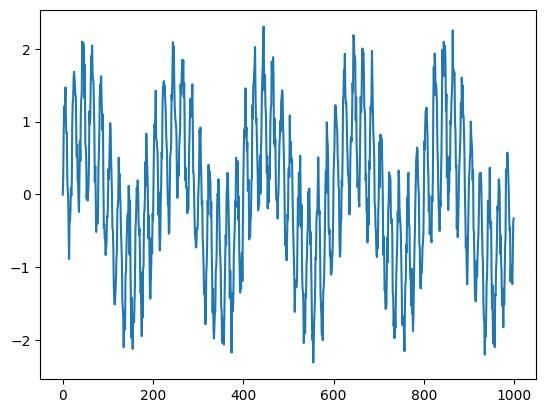

In [3]:
plt.figure()
plt.plot(toydata_1D[:1000])

## Calculate LPC from timeseries data

In [4]:
lpc_order=2
a1,e1,r1=analysis.arburg_vector(x=toydata_1D,order=lpc_order)
print(f"Case: PyLPC for vector data\n LPC coefficients: \n {a1}\n Reflection coeff: \n {r1} \n Sigma:{e1}")

AR, P, k = arburg(X=toydata_1D,order=lpc_order)
print(f"Case: Spectrum for vector data\n LPC coefficients: \n {AR}\n Reflection coeff: \n {k} \n Sigma:{P}")


a2,e2,r2=analysis.arburg_matrix(X=toydata_2D[:,:2],order=lpc_order)
print(f"Case: PyLPC for 2-column matrix data\n LPC coefficients: \n {a2}\n Reflection coeff: \n {r2} \n Sigma:{e2}")



Case: PyLPC for vector data
 LPC coefficients: 
 [-1.0224318   0.09023085]
 Reflection coeff: 
 [-0.93781221  0.09023085] 
 Sigma:0.12426629675568739
Case: Spectrum for vector data
 LPC coefficients: 
 [-1.0224318 +0.j  0.09023085-0.j]
 Reflection coeff: 
 [-0.93781221+0.j  0.09023085-0.j] 
 Sigma:0.12426629675570929
Case: PyLPC for 2-column matrix data
 LPC coefficients: 
 [[-1.0224318  -1.0224318 ]
 [ 0.09023085  0.09023085]]
 Reflection coeff: 
 [[-0.93781221 -0.93781221]
 [ 0.09023085  0.09023085]] 
 Sigma:[0.1242663 0.1242663]


## Performance Benchmark

### Function for Performance comparison

In [5]:
def get_timing(data,lpc_order,case_n):
    total_n=100
    timings=np.zeros((1,total_n))
    for i in range(total_n):
        start_time = time.time()
        if case_n==1:
            a1,e1,r1=analysis.arburg_vector(data,lpc_order)
        elif case_n==2:
            a2,e2,r2=analysis.arburg_matrix(data,lpc_order)
        elif case_n==3:
            AR, P, k = arburg(data,lpc_order)
        end_time = time.time()
        elapsed_time = end_time - start_time
        timings[0,i]=elapsed_time
    final_time=np.mean(timings)
    return final_time

### Run Benchmark

In [6]:
lpc_order=6

ts_lengths=[1e1, 1e2, 1e3, 1e4, 1e5] 
time_pylpc=np.zeros_like(ts_lengths)
time_spectrum=np.zeros_like(ts_lengths)

for i,ts in enumerate(ts_lengths):
    print(f"Case: {ts}")
    time_pylpc[i]=get_timing(toydata_1D[:int(ts)],lpc_order,case_n=1)
    time_spectrum[i]=get_timing(toydata_1D[:int(ts)],lpc_order,case_n=3)

    

Case: 10.0
Case: 100.0
Case: 1000.0
Case: 10000.0
Case: 100000.0


### Benchmark Results

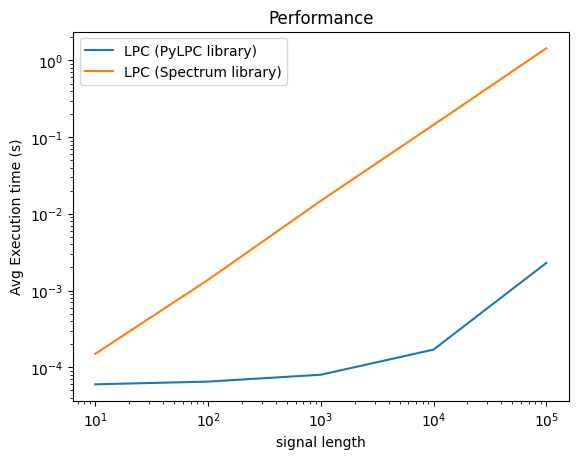

In [7]:
plt.figure()
plt.loglog(ts_lengths,time_pylpc,label="LPC (PyLPC library)")
plt.loglog(ts_lengths,time_spectrum,label="LPC (Spectrum library)")
plt.title('Performance')
plt.legend()
plt.xlabel('signal length')
plt.ylabel('Avg Execution time (s)')
plt.show()



## Frequency-warped LPC

In [8]:
lpc_order=2 # LPC order
freq_warping=0.2 # Frequency warping coefficient

a1,e1,r1=analysis.arburg_warped_vector(x=toydata_1D,order=lpc_order,warp_factor=freq_warping)
print(f"Case: PyLPC for vector data\n FW-LPC coefficients: \n {a1}\n Reflection coeff: \n {r1} \n Sigma:{e1}")


a2,e2,r2=analysis.arburg_warped_matrix(X=toydata_2D[:,:2],order=lpc_order,warp_factor=freq_warping)
print(f"Case: PyLPC for 2-column matrix data\n FW-LPC coefficients: \n {a2}\n Reflection coeff: \n {r2} \n Sigma:{e2}")


Case: PyLPC for vector data
 FW-LPC coefficients: 
 [-1.12952474  0.25228499]
 Reflection coeff: 
 [-0.90197099  0.25228499] 
 Sigma:0.18150334660764503
Case: PyLPC for 2-column matrix data
 FW-LPC coefficients: 
 [[-1.12952474 -1.12952474]
 [ 0.25228499  0.25228499]]
 Reflection coeff: 
 [[-0.90197099 -0.90197099]
 [ 0.25228499  0.25228499]] 
 Sigma:[0.18150335 0.18150335]


## LPC and Cepstrum coefficients

In [9]:
lpc_order=2 # LPC order
a1,e1,r1=analysis.arburg_vector(x=toydata_1D,order=lpc_order)
print(f"LPC coefficients: \n {a1}\n Reflection coeff: \n {r1} \n Sigma:{e1}")


c1=utils.arcoeff_to_cep(a=a1,sigma_squared=e1,N=4)
print(f"Cepstral Coefficient upto 4 elements: \n {c1}")

ac1=utils.cep_to_arcoeff(c=c1,order=lpc_order)
print(f"LPC from Cepstral Coefficient: \n {ac1}")


LPC coefficients: 
 [-1.0224318   0.09023085]
 Reflection coeff: 
 [-0.93781221  0.09023085] 
 Sigma:0.12426629675568739
Cepstral Coefficient upto 4 elements: 
 [-2.085328461594684, 1.0224318008243833, 0.43245254630349944, 0.26401719453835026]
LPC from Cepstral Coefficient: 
 [-1.0224318008243833, 0.09023084736499626]


## Power spectrum from LPC

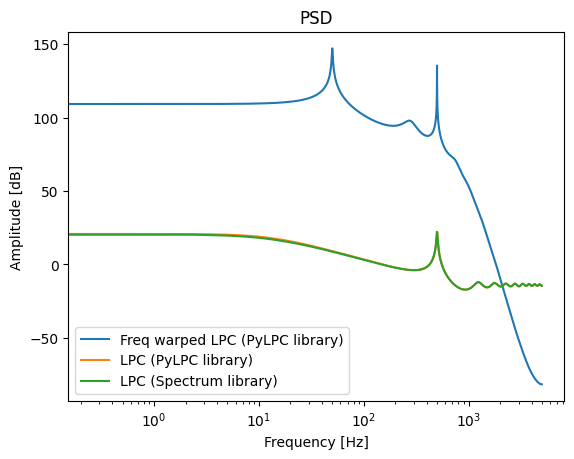

In [17]:
lpc_order=20 # LPC order
freq_warping=0.5 # Frequency warping coefficient

a1,e1,r1=analysis.arburg_warped_vector(x=toydata_1D,order=lpc_order,warp_factor=freq_warping)
a1=utils.arcoeff_warp(a=a1,warp_factor=freq_warping,task="unwarp")
w1,pwr1=utils.freqz(a=a1,sigma_squared=e1,worN=2*Fs,fs=Fs)

a1,e1,r1=analysis.arburg_vector(x=toydata_1D,order=lpc_order)
w2,pwr2=utils.freqz(a=a1,sigma_squared=e1,worN=2*Fs,fs=Fs)


AR, P, k = arburg(X=toydata_1D,order=lpc_order)
PSD = arma2psd(AR, rho=P, NFFT=2**12)
PSD = PSD[len(PSD):len(PSD)//2:-1]

plt.figure()
plt.semilogx(w1,pwr1,label="Freq warped LPC (PyLPC library)")
plt.semilogx(w2,pwr2,label="LPC (PyLPC library)")
plt.semilogx(np.linspace(0, Fs/2, len(PSD)), 10*np.log10(abs(PSD)),label='LPC (Spectrum library)')
plt.title('PSD')
plt.legend()
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [dB]')
plt.show()

## Time series generation from LPC model parameters

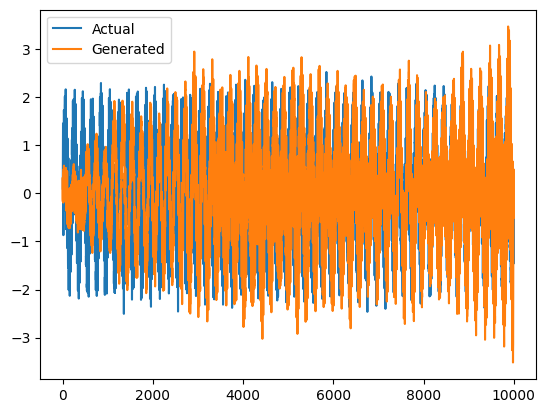

In [24]:
lpc_order=50 # LPC order
a1,e1,r1=analysis.arburg_vector(x=toydata_1D,order=lpc_order)

new_ts=synthesis.gen_ts(a=a1,sigma=np.sqrt(e1),n_samples=Fs)

plt.figure()
plt.plot(toydata_1D[:Fs],label="Actual")
plt.plot(new_ts,label="Generated")
plt.legend()

## Numerical accuracy of arcoeff_warp
arcoeff_warp uses scipy.signal.tf2zpk and scipy.signal.zpk2tf functions which are numerically inaccurate after 60th order

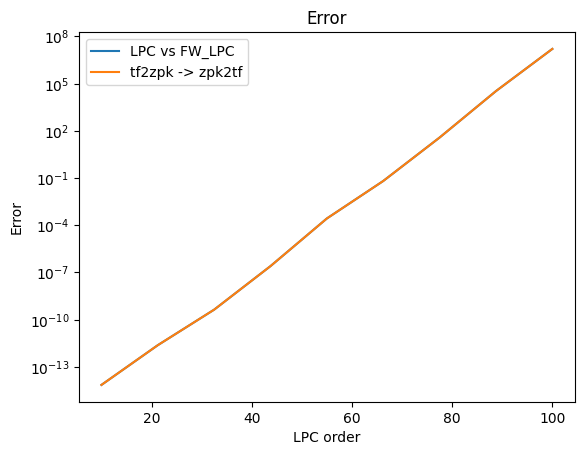

In [26]:
# LPC parameters
freq_warping=0.0 # Frequency warping coefficient

lpc_orders=np.linspace(10,100,9)
error1=np.zeros_like(lpc_orders)
error2=np.zeros_like(lpc_orders)

for i, lpc_order in enumerate(lpc_orders):
    lpc_order=int(lpc_order)
    # PSD from frequency-warped LPC model
    a1,e1,r1=analysis.arburg_warped_vector(x=toydata_1D,order=lpc_order,warp_factor=freq_warping)
    a11=utils.arcoeff_warp(a=a1,warp_factor=freq_warping,task="unwarp")
    # PSD from LPC model
    a0,e0,r0=analysis.arburg_vector(x=toydata_1D,order=lpc_order)

    # show the problem in scipy.signal.tf2zpk and scipy.signal.zpk2tf functions
    a=np.insert(a11, 0, 1)
    b=np.zeros_like(a)
    b[0]=1
    b2,a2=sig.zpk2tf(*sig.tf2zpk(b, a))

    error1[i]=np.linalg.norm(a0-a11)
    error2[i]=np.linalg.norm(a-a2)


# plot
plt.figure()
plt.semilogy(lpc_orders,error1,label="LPC vs FW_LPC")
plt.semilogy(lpc_orders,error1,label="tf2zpk --> zpk2tf")
plt.title('Error')
plt.legend()
plt.xlabel('LPC order')
plt.ylabel('Error')
plt.show()